## Installing Packages

In [1]:
# !pip3 install spotipy --upgrade
# !pip3 install pillow
# !pip3 install tensorflow

#### Importing Packages

In [2]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import pandas as pd
import requests
import collections
import pickle as pkl
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

## Using credentials to pull album art and popularity score (target variable) from Spotify's API (SpotiPy)

In [3]:
# User will have to create their own spotipy account and put their own CID and SECRET keys into the following variables
creds  = pd.read_csv('data/spotipy_credentials.csv', header = None)

cid    = creds[1][0]
secret = creds[1][1]

In [4]:
# Accessing API
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
# Creating list of playlists with independent artists to pull album art data from
fresh_finds_playlists = [
'https://open.spotify.com/playlist/37i9dQZF1DWT0upuUFtT7o',
'https://open.spotify.com/playlist/37i9dQZF1DWUFAJPVM3HTX',
'https://open.spotify.com/playlist/37i9dQZF1DX3u9TSHqpdJC',
'https://open.spotify.com/playlist/37i9dQZF1DWW4igXXl2Qkp',
'https://open.spotify.com/playlist/37i9dQZF1DX78toxP7mOaJ',
'https://open.spotify.com/playlist/37i9dQZF1DXdS3lvGe1GrT',
'https://open.spotify.com/playlist/37i9dQZF1DWYUfsq4hxHWP',
'https://open.spotify.com/playlist/37i9dQZF1DX6bBjHfdRnza',
'https://open.spotify.com/playlist/37i9dQZF1DX8C585qnMYHP',
'https://open.spotify.com/playlist/37i9dQZF1DXcWL5K0oNHcG',
'https://open.spotify.com/playlist/37i9dQZF1DWWjGdmeTyeJ6',
'https://open.spotify.com/playlist/37i9dQZF1DX7AqyNZFu97s',
'https://open.spotify.com/playlist/37i9dQZF1DXagUeYbNSnOA',
'https://open.spotify.com/playlist/37i9dQZF1DX5C8ObEZ48JQ',
'https://open.spotify.com/playlist/37i9dQZF1DX4Xz5lDbaehp',
'https://open.spotify.com/playlist/37i9dQZF1DX2ddCYH6QIK5',
'https://open.spotify.com/playlist/37i9dQZF1DX0KBgD4Jf5tY',
'https://open.spotify.com/playlist/37i9dQZF1DX5R53BjnKBjk',
'https://open.spotify.com/playlist/37i9dQZF1DX7vZYLzFGQXc',
'https://open.spotify.com/playlist/37i9dQZF1DXbDSHGzTpRHX',
'https://open.spotify.com/playlist/37i9dQZF1DWVhn3qoy98w6',
'https://open.spotify.com/playlist/37i9dQZF1DX34s4fg4Zx3Z',
'https://open.spotify.com/playlist/37i9dQZF1DX8pdK1PVpBQz',
'https://open.spotify.com/playlist/5CweKpXcP6I3p95u8zgIyb' #EDM
]

In [6]:
# looping through playlist lists to pull all tracks from each list
playlist_uris = []

for playlist in fresh_finds_playlists:
    playlist_uris.append(playlist.split("/")[-1].split("?")[0])

In [7]:
# Adding name of Genre to account for songs in multiple playlists
playlist_uri_to_name_dict = {}

for playlist_uri in playlist_uris:
    playlist_name = sp.user_playlist(user=None, playlist_id=playlist_uri, fields="name")['name']
    
    if playlist_name != "Fresh Finds":
        playlist_name = playlist_name.split(' ')[-1]
    else:
        playlist_name = 'All Genres'
        
    playlist_uri_to_name_dict[playlist_uri] = playlist_name

In [8]:
# Creating dict to append to
data={}
data['track_name'] = []
data['popularity'] = []
data['album_url'] = []
data['playlist_uri'] = []

# looping through each playlist
for playlist in playlist_uris:
    
    # looping through each track in playlist to append name, popularity rating (our target variable), and album url to pull artwork.
    for track in sp.playlist_tracks(playlist)["items"]:
        # track name
        data['track_name'].append(track["track"]["name"])
        # popularity of the track
        data['popularity'].append(track["track"]["popularity"])
        # Cover Art URL
        data['album_url'].append(track["track"]['album']['images'][0]['url'])
        # playlist URI for matching later
        data['playlist_uri'].append(playlist)

In [9]:
# creating dataframe from above dictionary
df = pd.DataFrame(data)

In [10]:
# adding in playlist genre
df['playlist_name'] = df.playlist_uri.replace(playlist_uri_to_name_dict)

In [11]:
# dropping any potential duplicates 
df = df.drop_duplicates().reset_index(drop = True)

In [12]:
# cleaning track names of characters for cleaner import and export
df['track_name_cleaned'] = df.track_name.str.replace("(?i)[^0-9a-z!?.;,@' -]",'')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('.','')
df['track_name_cleaned'] = df.track_name_cleaned.str.replace('*','')
df['track_name_cleaned'] = df.track_name_cleaned.str.strip()

df = df.loc[~(df.track_name_cleaned == '')]

In [13]:
# creating a key column to later link album artwork back to target variable ('popularity')
df['key'] = df['track_name_cleaned']+"_"+df['playlist_name']

In [14]:
# sorting data by trackname to match album art with popularity score
df = df.sort_values(by='key').reset_index(drop=True)

In [15]:
# Going through each URL, downloading the image, and saving it to album_art folder
error_list = []
for key, url in zip(df['key'], df['album_url']):
    
    try:
        img_data = requests.get(url).content
        with open(f'data/album_art/{key}.jpg', 'wb') as handler:
            handler.write(img_data)
    except:
        error_list.append(key)

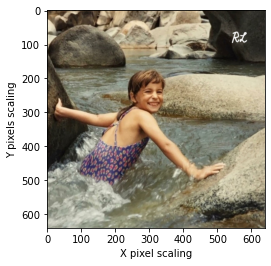

In [16]:
# Displaying example of photo
album_art_example = mpimg.imread("data/album_art/"+df.key[1463]+".jpg")
plt.imshow(album_art_example)

plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

plt.show()

In [17]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        image_dict[filename] = (mpimg.imread('data/album_art/'+file))
        
        # Not including image if it is not in uniform shape
        if image_dict[filename].shape == (640,640):
                image_dict[filename] = np.stack((image_dict[filename],)*3, axis=-1)
                
                newshape = image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if image_dict[filename].shape != (640,640,3):
            del image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Baby Choppa_2021.jpg was resized to (640, 640, 3)
Say Datt_Hip-Hop.jpg was resized to (640, 640, 3)
.DS_Store did not import
Spirito della Domenica_Italia.jpg was resized to (640, 640, 3)
Consolation Prize_Rock.jpg was resized to (640, 640, 3)
Something_NZ.jpg was resized to (640, 640, 3)
PDF_All Genres.jpg was resized to (640, 640, 3)
HEAVY METAL_2021.jpg was resized to (640, 640, 3)
Rave_All Genres.jpg was resized to (640, 640, 3)
Family Man_Rock.jpg was resized to (640, 640, 3)
concussion_2021.jpg was resized to (640, 640, 3)
Lost_NZ.jpg was resized to (640, 640, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (640, 640, 3)
White Picket Fence_2021.jpg was resized to (640, 640, 3)
At Least_Folk.jpg was resized to (640, 640, 3)
Portals_R&B.jpg was resized to (640, 640, 3)
Inconsciencia_Latin.jpg was resized to (640, 640, 3)
Rave_Dance.jpg was resized to (640, 640, 3)
BE FREE_R&B.jpg was resized to (640, 640, 3)
Be Your Lover_NZ.jpg was resized to (640, 640, 3)
Grimiest Ever_Dance.j

In [18]:
# filtering down dataframe so that only the files that were read in properly are included. 
filtered_df = df.loc[df.key.isin(image_dict.keys())]

In [19]:
# If image in dictionary is not found in dataframe with target values, delete from the dictionary. 
del_list = []

for key in image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print(key+' not fount in dataframe, delete from the album art dictionary')
        del_list.append(key)
        
for key in del_list:
    del image_dict[key]

4 Ya Kiss_Experimental not fount in dataframe, delete from the album art dictionary
.SYSTVMRVSTVRT not fount in dataframe, delete from the album art dictionary
.SYSTVMRVSTVRT* not fount in dataframe, delete from the album art dictionary


In [20]:
# Sorting Dictionary to match DataFrame order
image_dict = collections.OrderedDict(sorted(image_dict.items()))

In [21]:
# Checking if order of names matches, so we can accuractly match features with target data. 
if filtered_df.key.to_list() == list(image_dict.keys()):
    print('Data aligns')
else:
    print('Data does not align')

Data aligns


In [22]:
X = np.array(list(image_dict.values()))

In [23]:
X.shape

(1831, 640, 640, 3)

In [24]:
y = np.array(filtered_df.popularity).reshape(len(filtered_df.popularity), 1)

In [25]:
y.shape

(1831, 1)

In [26]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [27]:
X_train = X_train / 255
X_test  = X_test  / 255

In [28]:
# np.savez("test.npz", X_train)
# # test.npz is 2.95GB
np.savez_compressed("test2.npz", arr = X_train)
# test2.npz is 369MB

# DATA PULL PT. 2 - CHANGING PIXEL SIZE

Our first model took too much computational power, and was unable to exceed one epoch. If the pixels are reduced from >600 to 60, this should allow future models to run without complication

In [77]:
# # reading in album_art folder to resize and therefore minimize computational complexity and time
# for name in os.listdir('data/album_art'):
#     try:
#         img = Image.open('data/album_art/'+name)
#         img = img.resize((60,60))
#         img.save('data/album_art_resized/'+name)
#     except:
#         print(name+' did not import')

.DS_Store did not import


In [78]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
resized_image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art_resized/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        resized_image_dict[filename] = (mpimg.imread('data/album_art_resized/'+file))
        
        # Not including image if it is not in uniform shape
        if resized_image_dict[filename].shape == (60,60):
                resized_image_dict[filename] = np.stack((resized_image_dict[filename],)*3, axis=-1)
                
                newshape = resized_image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if resized_image_dict[filename].shape != (60,60,3):
            del resized_image_dict[filename]
                  
    except:
        print(file+' did not import')

Baby Choppa_2021.jpg was resized to (60, 60, 3)
Say Datt_Hip-Hop.jpg was resized to (60, 60, 3)
.DS_Store did not import
Spirito della Domenica_Italia.jpg was resized to (60, 60, 3)
Consolation Prize_Rock.jpg was resized to (60, 60, 3)
Something_NZ.jpg was resized to (60, 60, 3)
PDF_All Genres.jpg was resized to (60, 60, 3)
HEAVY METAL_2021.jpg was resized to (60, 60, 3)
Rave_All Genres.jpg was resized to (60, 60, 3)
Family Man_Rock.jpg was resized to (60, 60, 3)
concussion_2021.jpg was resized to (60, 60, 3)
Lost_NZ.jpg was resized to (60, 60, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (60, 60, 3)
White Picket Fence_2021.jpg was resized to (60, 60, 3)
At Least_Folk.jpg was resized to (60, 60, 3)
Portals_R&B.jpg was resized to (60, 60, 3)
Inconsciencia_Latin.jpg was resized to (60, 60, 3)
Rave_Dance.jpg was resized to (60, 60, 3)
BE FREE_R&B.jpg was resized to (60, 60, 3)
Be Your Lover_NZ.jpg was resized to (60, 60, 3)
Grimiest Ever_Dance.jpg was resized to (60, 60, 3)
WORK 4 A

In [79]:
# filtering down dataframe so that only the files that were read in properly are included. 
resized_filtered_df = df.loc[df.key.isin(resized_image_dict.keys())]

In [80]:
del_list = []

for key in resized_image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del resized_image_dict[key]

Could not find associated value for .SYSTVMRVSTVRT, delete from the album art dictionary
Could not find associated value for .SYSTVMRVSTVRT*, delete from the album art dictionary


In [81]:
# Sorting Dictionary to match DataFrame order
resized_image_dict = collections.OrderedDict(sorted(resized_image_dict.items()))

In [82]:
# Checking if order of names matches, so we can accuractly match features with target data. 
if resized_filtered_df.key.to_list() == list(resized_image_dict.keys()):
    print('Data aligns')
else:
    print('Data does not align')

Data aligns
